In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import time

import imageio
import glob
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
#from tensorflow_docs.vis import embed
from sklearn.model_selection import train_test_split
#!pip install -q git+https://github.com/tensorflow/docs
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import imageio
from scipy.linalg import sqrtm
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image


# Initialize rng
rng = np.random.default_rng(2022)

auc = tf.keras.metrics.AUC()

In [ ]:
batch_size = 32 # This is a tunable hyperparameter
shape = (128, 128) # note we are reducing the size of the image

data_dir = '/content/drive/MyDrive/Eye_Dataset/'

train_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'train_new'),
                                                       seed=rng.integers(500000),
                                                       image_size=shape,
                                                       label_mode="categorical",
                                                       color_mode='grayscale',
                                                       batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'validation/validation'),
                                                     seed=rng.integers(500000),
                                                     image_size=shape,
                                                     label_mode="categorical",
                                                     color_mode='grayscale',
                                                     batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir, 'test_new'),
                                                      seed=rng.integers(500000),
                                                      image_size=shape,
                                                      color_mode='grayscale',
                                                      batch_size=batch_size)

Found 16000 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.
Found 4000 files belonging to 4 classes.


In [ ]:
# Check shape of data
for x, y in train_ds.take(1):
  print(x.shape)
  print(y.shape)

(32, 128, 128, 1)
(32, 4)


In [ ]:
 for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

Images batch shape: (32, 128, 128, 1)
Labels batch shape: (32, 4)


In [ ]:
train_dir = '/content/drive/MyDrive/Eye_Dataset/train_new'

class_names_list = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
class_names_list

['DME', 'DRUSEN', 'NORMAL', 'CNV']

In [ ]:
# Number of classes (4 in your case: 'CNV', 'DME', 'DRUSEN', 'NORMAL')
num_classes = len(class_names_list)
num_classes

4

Initialize Hyperparameter

In [ ]:
buffer_size = 16000
batch_size = 64
num_channels = 1
num_classes = len(class_names_list)
image_size = 128
latent_dim = 100

In [ ]:
# normalize image pixels into range [-1, 1]
def normalize(image, label):
  """
  The normalization function will transform each image pixel value to the range [-1, 1], while the labels remain unchanged.

  """
  image = (image - 127.5) / 127.5
  return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)
train_ds


<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
# Add class labels in one-hot encoding to the generator input and discriminator input
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

104 5


Create Generator / Discriminator

In [ ]:
# # Create the discriminator.
# discriminator = keras.Sequential(
#     [
#         keras.layers.InputLayer((128, 128, discriminator_in_channels)),
#         layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
#         layers.LeakyReLU(alpha=0.2),
#         layers.GlobalMaxPooling2D(),
#         layers.Dense(1),
#     ],
#     name="discriminator",
# )

# # Create the generator.
# generator = keras.Sequential(
#     [
#         keras.layers.InputLayer((generator_in_channels,)),
#         layers.Dense(8 * 8 * 256),  # Start with an 8x8 feature map
#         layers.LeakyReLU(alpha=0.2),
#         layers.Reshape((8, 8, 256)),
#         layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),  # Upscale to 16x16
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),  # Upscale to 32x32
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),   # Upscale to 64x64
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"),   # Upscale to 128x128
#         layers.LeakyReLU(alpha=0.2),
#         layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),      # Produce final output
#     ],
#     name="generator",
# )

In [ ]:
# Improved discriminator
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((128, 128, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(4, activation="softmax"),
    ],
    name="discriminator",
)

# Improved generator
generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        layers.Dense(8 * 8 * 512),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((8, 8, 512)),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (7, 7), padding="same", activation="tanh"),  # Assuming RGB images
    ],
    name="generator",
)


Conditional GAN

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[128 * 128]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)
        print("Generated images shape:", generated_images.shape)
        print("Image one hot labels shape:", image_one_hot_labels.shape)


        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


Epoch 1/20
500/500 [==============================] - 59s 114ms/step - g_loss: 16.2044 - d_loss: 8.5261e-08
Epoch 2/20
500/500 [==============================] - 53s 105ms/step - g_loss: 16.4801 - d_loss: 6.6210e-08
Epoch 3/20
500/500 [==============================] - 55s 109ms/step - g_loss: 16.8705 - d_loss: 4.9112e-08
Epoch 4/20
500/500 [==============================] - 56s 111ms/step - g_loss: 17.1224 - d_loss: 3.6961e-08
Epoch 5/20
500/500 [==============================] - 54s 106ms/step - g_loss: 17.1525 - d_loss: 3.0298e-08
Epoch 6/20
500/500 [==============================] - 54s 106ms/step - g_loss: 17.1991 - d_loss: 2.6629e-08
Epoch 7/20
500/500 [==============================] - 56s 110ms/step - g_loss: 17.2974 - d_loss: 2.2248e-08
Epoch 8/20
500/500 [==============================] - 53s 105ms/step - g_loss: 17.4927 - d_loss: 1.8606e-08
Epoch 9/20
500/500 [==============================] - 53s 104ms/step - g_loss: 17.7319 - d_loss: 1.4453e-08
Epoch 10/20
500/500 [=======

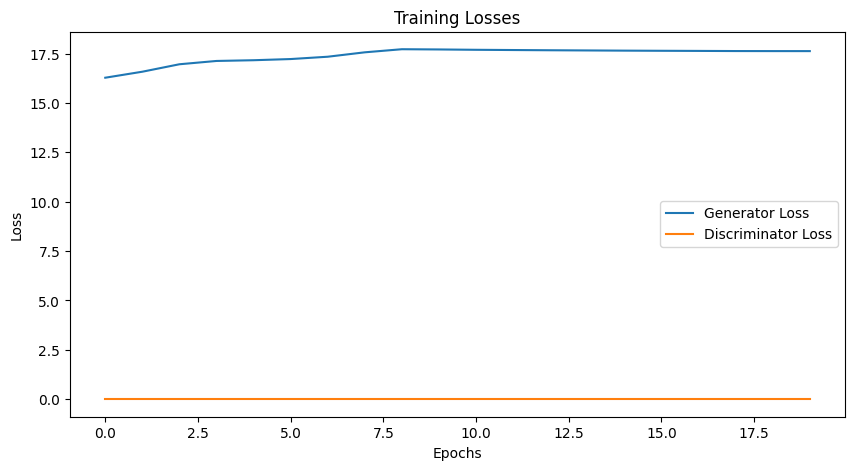

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.generator_losses = []
        self.discriminator_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.generator_losses.append(logs.get('g_loss'))
        self.discriminator_losses.append(logs.get('d_loss'))

loss_history = LossHistory()

history = cond_gan.fit(
    train_ds,
    epochs=20,
    callbacks=[loss_history]
)

# Plot loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history.generator_losses, label='Generator Loss')
plt.plot(loss_history.discriminator_losses, label='Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Conditional GAN model training

In [ ]:
# Measure training time
start_time = time.time()
print("start ", start_time)

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(train_ds, epochs=20)

end_time = time.time()
total_time = (end_time - start_time)/60
print(f"Training time: {total_time} mins")


start  1702070175.8340788
Epoch 1/20
Generated images shape: (None, 128, 128, 1)
Image one hot labels shape: (None, 128, 128, 4)
Generated images shape: (None, 128, 128, 1)
Image one hot labels shape: (None, 128, 128, 4)
500/500 [==============================] - 2956s 6s/step - g_loss: 4.5326 - d_loss: 0.0951
Epoch 2/20
500/500 [==============================] - 53s 106ms/step - g_loss: 8.6124 - d_loss: 1.7252e-04
Epoch 3/20
500/500 [==============================] - 53s 105ms/step - g_loss: 9.7226 - d_loss: 5.4424e-05
Epoch 4/20
500/500 [==============================] - 53s 106ms/step - g_loss: 10.4936 - d_loss: 2.5395e-05
Epoch 5/20
500/500 [==============================] - 57s 112ms/step - g_loss: 11.1017 - d_loss: 1.3844e-05
Epoch 6/20
500/500 [==============================] - 53s 105ms/step - g_loss: 11.5962 - d_loss: 8.4700e-06
Epoch 7/20
500/500 [==============================] - 53s 105ms/step - g_loss: 12.0340 - d_loss: 5.4917e-06
Epoch 8/20
500/500 [======================

Visualize Generated Images

In [ ]:
def calculate_accuracy(model, dataset):
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

    for images, labels in dataset:
        # Reshape the labels to match the image dimensions and concatenate
        image_one_hot_labels = labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[images.shape[1] * images.shape[2]]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, [-1, images.shape[1], images.shape[2], labels.shape[1]]
        )
        combined_input = tf.concat([images, image_one_hot_labels], axis=-1)

        # Predict labels using the model
        logits = model(combined_input, training=False)
        accuracy_metric.update_state(labels, logits)

    return accuracy_metric.result().numpy()


In [ ]:
train_accuracy = calculate_accuracy(cond_gan.discriminator, train_ds)
val_accuracy = calculate_accuracy(cond_gan.discriminator, val_ds)
#test_accuracy = calculate_accuracy(cond_gan.discriminator, test_ds)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {val_accuracy}")
#print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.25
Validation Accuracy: 0.25


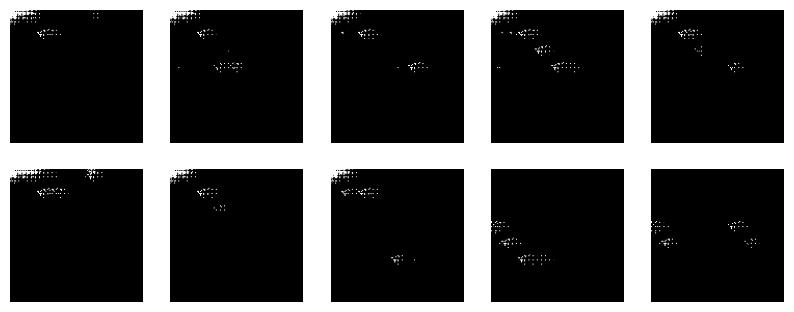

In [ ]:
def plot_generated_images(generator, num_examples=10, num_classes=4):
    # Generate noise for the generator
    noise = tf.random.normal([num_examples, latent_dim])

    # Generate random one-hot encoded labels
    random_labels = np.random.randint(0, num_classes, size=num_examples)
    one_hot_labels = tf.one_hot(random_labels, num_classes)

    # Concatenate noise and labels
    generator_input = tf.concat([noise, one_hot_labels], axis=1)

    # Generate images
    generated_images = generator(generator_input)

    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

plot_generated_images(cond_gan.generator, num_examples=10, num_classes=4)

Plot Training Losses

Evaluate validation set

In [ ]:
def display_predictions(model, dataset):
    for images, labels in dataset.take(1):  # Take 1 batch from the dataset
        predictions = model(images, training=False)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels, axis=1)

        plt.figure(figsize=(10, 10))
        for i in range(25):  # Assuming the batch size is at least 25
            plt.subplot(5, 5, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap=plt.cm.binary)
            plt.xlabel(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
        plt.show()

# Call the function with your model and dataset
display_predictions(cond_gan.discriminator, val_ds)